### Workflow -- Forward Modeling

1. [For a given mantle composition, use perplex to generate material properties for T-P field (convert P to Z)](perplex/Plot_PT.ipynb)
2. [Assume a value for heatflow, then use xenoliths to invert for a range of geotherms](geotherm/Invert_for_Geotherm.ipynb)
3. Make a velocity model
  * Crustal constraints pulled from Crust1.0
  * Mantle constraints from perplex calculation
4. Run Mineos to compute phase velocities and compare with observations

In [1]:
#Step 1 - Import mappings for P-T calculation
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pylab as plt
plt.style.use('ggplot')

import pickle
fin = open('perplex/funs.pickle','rb')
[frho,fvp,fvs] = pickle.load(fin)
fin.close()

In [2]:
#Step 2 - Import range of geotherms
from geotherm import *
fig = plt.figure(1,(6,6))

gts={}

for tag in ['min','max']:

    fin = open('geotherm/geotherm_ColoradoPlateau_%s.pickle' % tag,'rb')
    gt = pickle.load(fin)
    fin.close()

    plt.plot(gt.temps,gt.depths,label='%.2f $\mu$W/m$^3$' % (gt.rhoH*10**6), lw=3)
    
    gts[tag] = gt
    
plt.scatter(gt.xeno_temps,gt.xeno_depths, label = 'xenoliths',zorder=1000, color='black')
plt.title('Heat Flow: %2d mW/m$^2$' % (gt.q0*1e3) )
plt.ylim(max(gt.depths),0)
_,_=plt.ylabel('Depth (km)'), plt.xlabel('Temperature ($^\circ$C)')
_ =plt.legend(loc=3)

Crust 1.0 at lat, lon = 36.00 -110.00
     Vp    Vs  Density  Bottom   Label
0  1.50  0.00     1.02    1.98   Water
1  3.81  1.94     0.92    1.98     Ice
2  2.50  1.07     2.11    0.98   Seds1
3  4.60  2.59     2.46    0.48   Seds2
4  0.00  0.00     0.00    0.48   Seds3
5  6.10  3.55     2.74  -17.17  Crust1
6  6.30  3.65     2.78  -32.82  Crust2
7  7.00  3.99     2.95  -39.64  Crust3


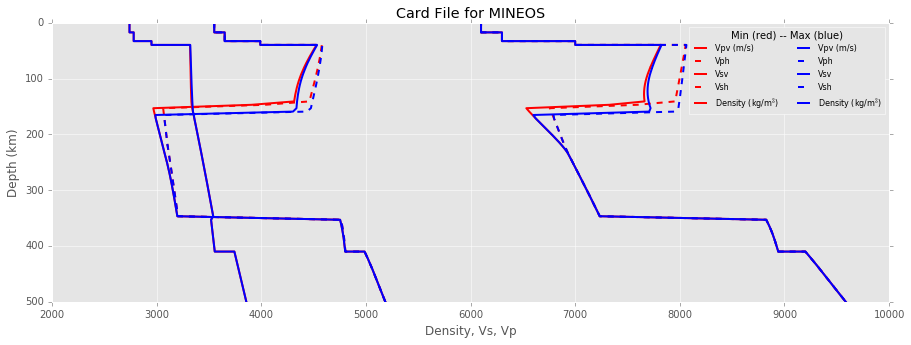

In [3]:
#Step 3 - Make velocity model and write to card file
from matplotlib import pylab as plt
%matplotlib inline
plt.style.use('ggplot')

from crust1.crust1 import Crust1
c = Crust1().load('crust1/crustal_model_ColoradoPlateau.pickle').print()

ziface1 = abs(c.model.Bottom[5])
ziface2 = abs(c.model.Bottom[6])
zmoho = abs(c.model.Bottom[7])

def extract_profile(fun, crustal_property_column, gt):
    from scipy.interpolate import interp1d
    
    vs, zs = [],[]
    for ii, eachz in enumerate(gt.depths):
        
        val = fun(gt.temps[ii], eachz)
        
        for ilay in [7,6,5]:
            zcritical = abs(c.model.Bottom[ilay])
            if eachz < zcritical:
                val = crustal_property_column[ilay]
            
        vs.append(val)
        zs.append(eachz)

    #_ = plt.plot(vs, zs, lw = 2)
    #plt.ylim([max(zs),0])
    
    return interp1d(zs,vs)
    
#plt.figure(1)
#_ = plt.title("Results of Perple_X Calculations")

from minos.minos import CardFile

ls = ['red','blue']

for kk,tag in enumerate(gts):
    fvp_crst  = extract_profile(fvp, c.model.Vp, gts[tag])
    fvs_crst  = extract_profile(fvs, c.model.Vs, gts[tag])
    frho_crst = extract_profile(frho, c.model.Density, gts[tag])

    cf = CardFile().read('minos/STW105.txt')
    cf0 = CardFile().read('minos/STW105.txt')
    cf0=cf0.set_mantle_region(fvp_crst, fvs_crst, frho_crst, zmoho=zmoho)
    cf0=cf0.set_crustal_region(c.model)
    cf0.write('minos/%s.txt' % tag)

    plt.figure(2,figsize=(15,5))
    _ = plt.plot(cf0.df.Vpv, 6371-cf0.df.Radius/1000, lw = 2, label = 'Vpv (m/s)', c=ls[kk])
    _ = plt.plot(cf0.df.Vph, 6371-cf0.df.Radius/1000, lw = 2, label = 'Vph', c=ls[kk], ls ='--')
    #_ = plt.plot(cf.df.Vpv, 6371-cf.df.Radius/1000, '--k', lw = 0.5)
    _ = plt.ylim(500,0)

    _ = plt.plot(cf0.df.Vsv, 6371-cf0.df.Radius/1000,label='Vsv', lw=2, c=ls[kk])
    _ = plt.plot(cf0.df.Vsh, 6371-cf0.df.Radius/1000,label='Vsh', lw=2, c=ls[kk], ls ='--')
    #_ = plt.plot(cf.df.Vsv, 6371-cf.df.Radius/1000, '--k', lw = 0.5)

    _ = plt.plot(cf0.df.Density, 6371-cf0.df.Radius/1000,label='Density (kg/m$^3$)', lw=2, c=ls[kk])
    #_ = plt.plot(cf.df.Density, 6371-cf.df.Radius/1000, '--k', lw = 0.5)

_ = plt.ylim(500,0)
_ = plt.xlim(2000, 10000)
_ = plt.title("Card File for MINEOS")
_ = plt.ylabel('Depth (km)')
_ = plt.xlabel('Density, Vs, Vp')
_ = plt.legend(ncol=2,fontsize=8,title='Min (red) -- Max (blue)')

**Note**: At depths > 350 km, the Card File pulls direct values from STW105, resulting in artificial discontinuities around that depth.

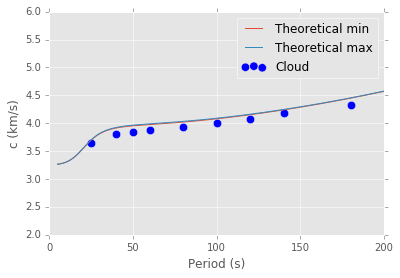

In [4]:
#Step 4 - Compute phase velocities and compare with observed

from minos.minos import Minos
from cloud.observations import PhaseVelocities
pv = PhaseVelocities(36,-110)

for tag in gts:
    minos = Minos(tag).run().read_output()

    _ = plt.plot(minos.period, minos.c, label='Theoretical %s' % tag)
    xs,ys = [],[]
    for key in pv.measurements:
        xs.append(key)
        ys.append(pv.measurements[key]/1000.)


plt.figure(1,(9,9))
_ = plt.scatter(xs,ys,s=70,label='Cloud')
    
plt.xlim(0,200)
plt.ylim(2,6)
plt.ylabel('c (km/s)')
plt.xlabel('Period (s)')

_ = plt.legend()